# S2 RA ETBF region crop

**Date:** <br>
18 December 2021 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='01:00:00')
client = Client(cluster)
cluster.scale(cores=24)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.130:41803,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


***

# load ETBF export NC files for S2

In [6]:
import glob
ETBF_NC_data = xr.merge([xr.open_dataset(f) for f in glob.glob('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/*.nc')]).drop({'depth'})

In [7]:
ETBF_NC_data

<xarray.Dataset>
Dimensions:   (time: 480, lon: 360, lat: 180)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2020-12-01
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables: (12/17)
    d20       (time, lat, lon) float32 ...
    sst       (time, lat, lon) float32 ...
    eke300    (time, lat, lon) float32 ...
    hc300     (time, lat, lon) float32 ...
    sss       (time, lat, lon) float32 ...
    temp50    (time, lat, lon) float32 ...
    ...        ...
    mld2      (time, lat, lon) float32 ...
    td        (time, lat, lon) float32 ...
    v100      (time, lat, lon) float32 ...
    u100      (time, lat, lon) float32 ...
    mld1      (time, lat, lon) float32 ...
    temp100   (time, lat, lon) float32 ...

# crop region

In [8]:
ETBF_NC_data_AUSregion = ETBF_NC_data.sel({'lon':slice(100,240),'lat':slice(-60,5)})

In [9]:
ETBF_NC_data_AUSregion

<xarray.Dataset>
Dimensions:   (time: 480, lon: 80, lat: 65)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2020-12-01
  * lon       (lon) float64 100.5 101.5 102.5 103.5 ... 176.5 177.5 178.5 179.5
  * lat       (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ... 1.5 2.5 3.5 4.5
Data variables: (12/17)
    d20       (time, lat, lon) float32 ...
    sst       (time, lat, lon) float32 ...
    eke300    (time, lat, lon) float32 ...
    hc300     (time, lat, lon) float32 ...
    sss       (time, lat, lon) float32 ...
    temp50    (time, lat, lon) float32 ...
    ...        ...
    mld2      (time, lat, lon) float32 ...
    td        (time, lat, lon) float32 ...
    v100      (time, lat, lon) float32 ...
    u100      (time, lat, lon) float32 ...
    mld1      (time, lat, lon) float32 ...
    temp100   (time, lat, lon) float32 ...

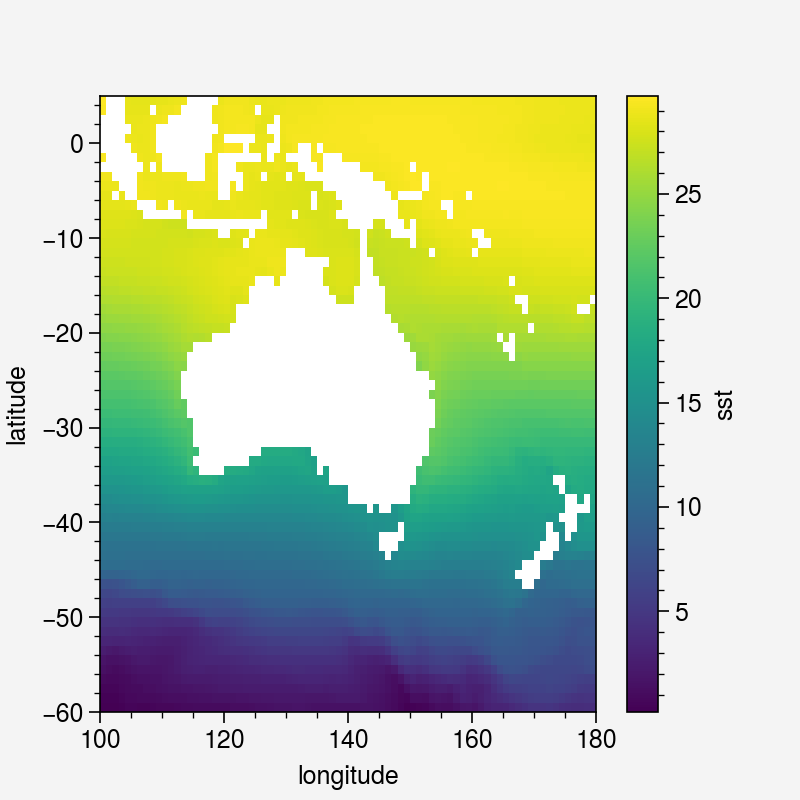

In [10]:
ETBF_NC_data_AUSregion.sst.mean('time').plot()

In [11]:
ETBF_NC_data_AUSregion.nbytes/1e9

0.169733

In [12]:
%%time
ETBF_NC_data_AUSregion.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/AUS_region/accessS2.RA.ETBFvars.masked.grid1deg.nc')

CPU times: user 3.37 s, sys: 3.27 s, total: 6.64 s
Wall time: 28.1 s


***

# load BRAN2020

## get gridspec

In [9]:
BRAN_grid_spec = xr.open_dataset('/g/data/gb6/BRAN/BRAN2020/static/grid_spec.nc')

## load temperature, mld, u etc

In [10]:
ds_BRAN_temp = xr.open_mfdataset('/g/data/gb6/BRAN/BRAN2020/month/ocean_temp_mth*.nc',parallel=True)

In [11]:
ds_BRAN_mld = xr.open_mfdataset('/g/data/gb6/BRAN/BRAN2020/month/ocean_mld_mth*.nc',parallel=True)

In [12]:
ds_BRAN_u = xr.open_mfdataset('/g/data/gb6/BRAN/BRAN2020/month/ocean_u_mth*.nc',parallel=True)

In [13]:
ds_BRAN_v = xr.open_mfdataset('/g/data/gb6/BRAN/BRAN2020/month/ocean_v_mth*.nc',parallel=True)

***

# load CAFE60

In [14]:
ds_CAFE60 = xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')

***

# load obs - RG2019

In [15]:
ds_RG2019_temp = xr.open_dataset('/g/data/v14/tm4888/data/observations/RG2019/RG_ArgoClim_Temperature_2019.nc', decode_times=False)
ds_RG2019_salt = xr.open_dataset('/g/data/v14/tm4888/data/observations/RG2019/RG_ArgoClim_Salinity_2019.nc', decode_times=False)

In [16]:
ds_RG2019 = xr.merge([ds_RG2019_temp,ds_RG2019_salt])

In [17]:
ds_RG2019.TIME.attrs['calendar']='360_day'
ds_RG2019 = xr.decode_cf(ds_RG2019,use_cftime=True)

In [18]:
RG2019_temp_test = (ds_RG2019.ARGO_TEMPERATURE_ANOMALY.isel({'PRESSURE':0,'TIME':90}) + ds_RG2019.ARGO_TEMPERATURE_MEAN.isel({'PRESSURE':0}))

In [19]:
RG2019_temp = (ds_RG2019.ARGO_TEMPERATURE_ANOMALY + ds_RG2019.ARGO_TEMPERATURE_MEAN)

***

In [20]:
RG2019_EAC = RG2019_temp.sel({'LONGITUDE':slice(140,180),'LATITUDE':slice(-40,-20)}).mean(['LONGITUDE','LATITUDE'])
RG2019_EAC.compute()

<xarray.DataArray (TIME: 180, PRESSURE: 58)>
array([[23.485056 , 23.400187 , 23.181103 , ...,  2.601728 ,  2.4672794,
         2.3866677],
       [24.202677 , 24.139824 , 23.945688 , ...,  2.5920565,  2.4641771,
         2.3825421],
       [23.845299 , 23.831371 , 23.789097 , ...,  2.590883 ,  2.4606094,
         2.3788157],
       ...,
       [19.969881 , 19.896149 , 19.76833  , ...,  2.6017992,  2.4684746,
         2.383095 ],
       [21.036392 , 20.972857 , 20.813213 , ...,  2.602894 ,  2.470664 ,
         2.385792 ],
       [22.422619 , 22.329908 , 22.15755  , ...,  2.602155 ,  2.4668667,
         2.380363 ]], dtype=float32)
Coordinates:
  * PRESSURE  (PRESSURE) float32 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
  * TIME      (TIME) object 2004-01-16 00:00:00 ... 2018-12-16 00:00:00

In [ ]:
CAFE60_EAC = ds_CAFE60.temp.sel({'xt_ocean':slice(-220,-180),'yt_ocean':slice(-40,-20)}).mean(['xt_ocean','yt_ocean','ensemble']).compute()

In [ ]:
BRAN_EAC = ds_BRAN_temp.temp.sel({'xt_ocean':slice(140,180),'yt_ocean':slice(-40,-20)}).mean(['xt_ocean','yt_ocean']).compute()

In [ ]:
S2_EAC = ETBF_NC_data.temp500.sel({'lon':slice(140,180),'lat':slice(-40,-20)}).mean(['lon','lat']).compute()

In [ ]:
S2_EAC.rename({'datetime64','time'})

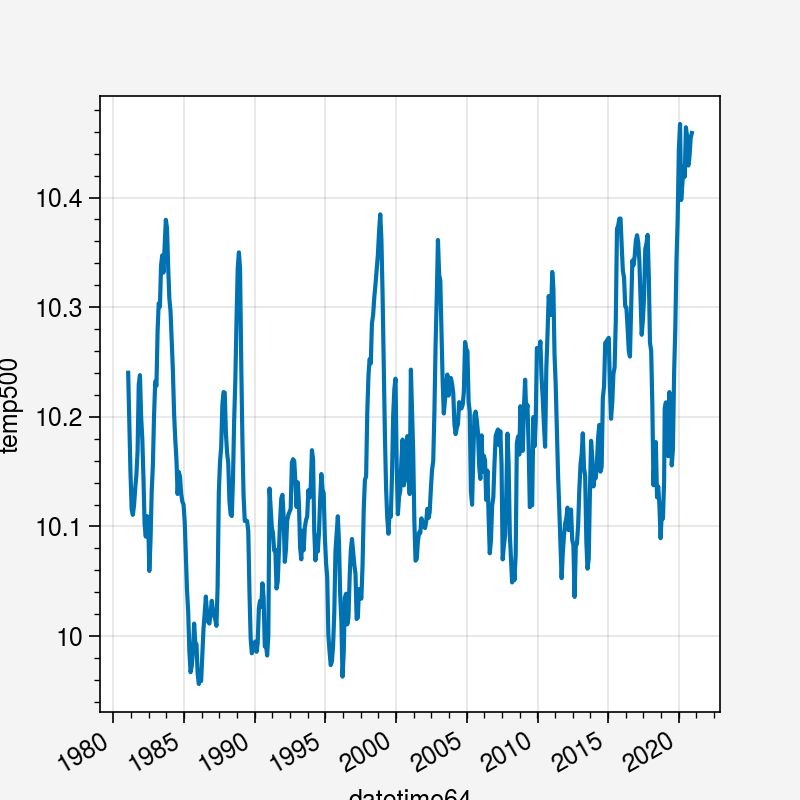

In [56]:
S2_EAC.plot()

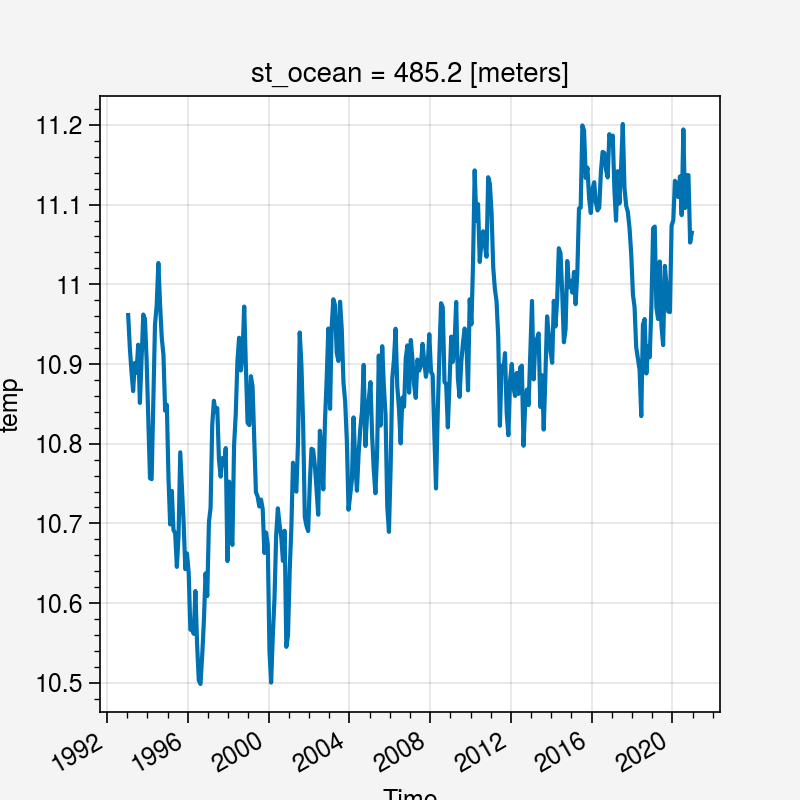

In [50]:
BRAN_EAC.sel(st_ocean=500,method='nearest').plot()

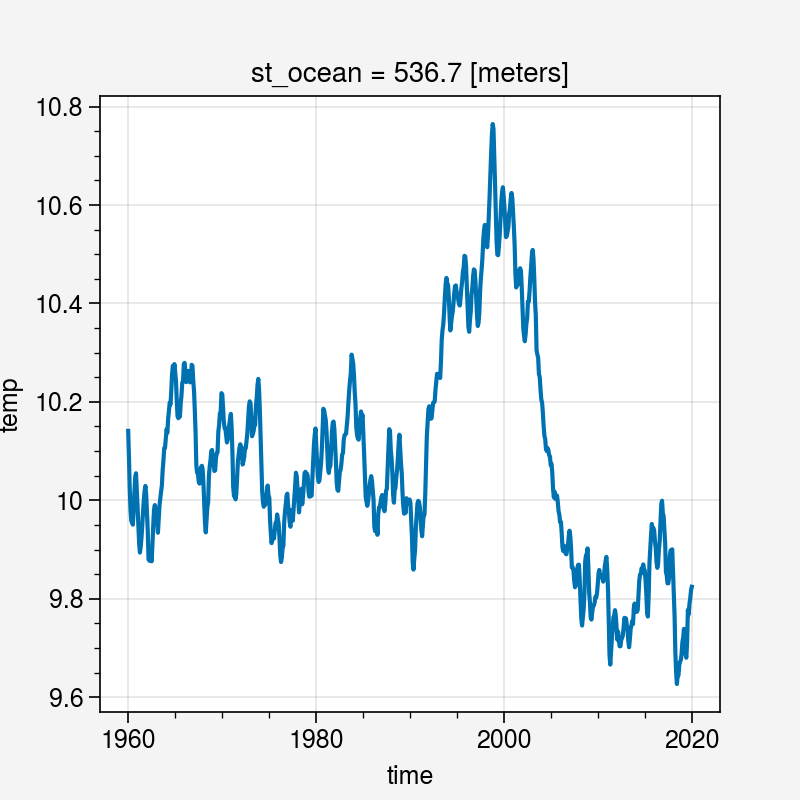

In [51]:
CAFE60_EAC.sel(st_ocean=500,method='nearest').plot()

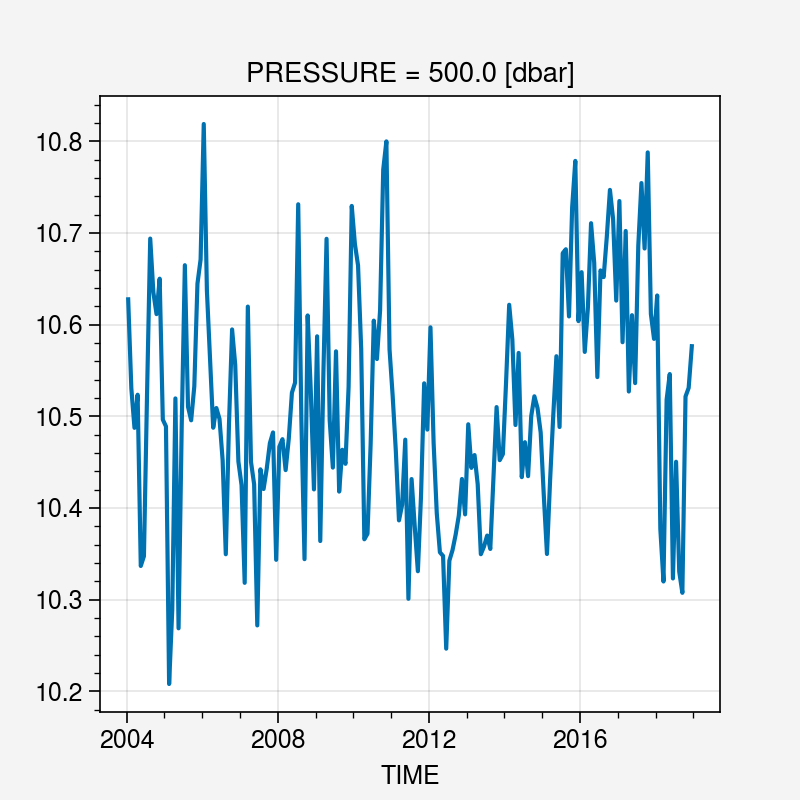

In [52]:
RG2019_EAC.sel(PRESSURE=500,method='nearest').plot()

In [58]:
CAFE60_EAC.sel(st_ocean=500,method='nearest').plot(color='k')
RG2019_EAC.sel(PRESSURE=500,method='nearest').plot(color='g')
BRAN_EAC.sel(st_ocean=500,method='nearest').plot(color='b')
S2_EAC.plot(color='r')

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'numpy.str_'

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'numpy.str_'

<Figure size 400x400 with 1 Axes>

# $\big\Downarrow$ This has been run on 7 Dec 2021

# SST

In [ ]:
%%time
sst = ds_Tocean.sst
sst_025 = ds_025_Tocean.sst
sst.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.SST.grid1deg.nc')
sst_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.SST.nativegrid.nc')

# SSS

In [ ]:
%%time
sss = ds_Tocean.sss
sss_025 = ds_025_Tocean.sss
sss.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.SSS.grid1deg.nc')
sss_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.SSS.nativegrid.nc')

# mld1

In [ ]:
%%time
mld1 = ds_Tocean.mld1
mld1_025 = ds_025_Tocean.mld1
mld1.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld1.grid1deg.nc')
mld1_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld1.nativegrid.nc')

# mld2

In [ ]:
%%time
mld2 = ds_Tocean.mld2
mld2_025 = ds_025_Tocean.mld2
mld2.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld2.grid1deg.nc')
mld2_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld2.nativegrid.nc')

# td

In [ ]:
%%time
td = ds_Tocean.td
td_025 = ds_025_Tocean.td
td.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.td.grid1deg.nc')
td_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.td.nativegrid.nc')

# temp50

In [ ]:
%%time
temp50 = ds_Tocean.temp50
temp50_025 = ds_025_Tocean.temp50
temp50.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp50.grid1deg.nc')
temp50_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp50.nativegrid.nc')

# temp100

In [ ]:
%%time
temp100 = ds_Tocean.temp100
temp100_025 = ds_025_Tocean.temp100
temp100.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp100.grid1deg.nc')
temp100_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp100.nativegrid.nc')

# temp200

In [ ]:
%%time
temp200 = ds_Tocean.temp200
temp200_025 = ds_025_Tocean.temp200
temp200.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp200.grid1deg.nc')
temp200_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp200.nativegrid.nc')

# temp500

In [ ]:
%%time
temp500 = ds_Tocean.temp500
temp500_025 = ds_025_Tocean.temp500
temp500.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp500.grid1deg.nc')
temp500_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp500.nativegrid.nc')

# temp sanity checks

In [ ]:
#build datasets
temp_1deg = xr.merge([temp50,temp100,temp200,temp500])
temp_025 = xr.merge([temp50_025,temp100_025,temp200_025,temp500_025])

In [ ]:
import proplot as pplt
import numpy as np
pplt.rc.cycle = '538'
fig, axs = pplt.subplots(ncols=1, span=False, share='labels', refwidth=5.3)
labels = ['50', '100', '200', '500']
hs1 = []
region = {'lat':slice(-50,-15),'lon':slice(150,180)}
for i, label in enumerate(labels):
    var_string = 'temp'+label
    data = temp_1deg[var_string].sel(region).mean({'lat','lon'})
    h1 = axs[0].plot(
        data, lw=2, label=label, alpha=0.7
    )
    hs1.extend(h1)

# Outer legends
ax = axs[0]
ax.legend(hs1, loc='b', ncols=3, title='depth in metres', order='C', facecolor='gray2')
axs.format(xlabel='date', ylabel='temp', suptitle='ocean temp sanity check - 1deg grid')

In [ ]:
import proplot as pplt
import numpy as np
pplt.rc.cycle = '538'
fig, axs = pplt.subplots(ncols=1, span=False, share='labels', refwidth=5.3)
labels = ['50', '100', '200', '500']
hs1 = []
region = {'lat':slice(-50,-15),'lon':slice(150,180)}
for i, label in enumerate(labels):
    var_string = 'temp'+label
    data = temp_025[var_string].sel(region).mean({'lat','lon'})
    h1 = axs[0].plot(
        data, lw=2, label=label, alpha=0.7
    )
    hs1.extend(h1)

# Outer legends
ax = axs[0]
ax.legend(hs1, loc='b', ncols=3, title='depth in metres', order='C', facecolor='gray2')
axs.format(xlabel='date', ylabel='temp', suptitle='ocean temp sanity check - 0.25deg grid')

In [ ]:
temp500_025

# U100

In [ ]:
%%time
u100 = ds_u.u.sel(depth=100,method='nearest')
u100_025 = ds_025_u.u.sel(depth=100,method='nearest')
u100.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100.grid1deg.nc')
u100_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100.nativegrid.nc')

# V100

In [ ]:
%%time
v100 = ds_v.v.sel(depth=100,method='nearest')
v100_025 = ds_025_v.v.sel(depth=100,method='nearest')
v100.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100.grid1deg.nc')
v100_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100.nativegrid.nc')

# D20

In [ ]:
%%time
d20 = ds_Tocean.d20
d20_025 = ds_025_Tocean.d20
d20.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.d20.grid1deg.nc')
d20_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.d20.nativegrid.nc')

# hc300

In [ ]:
%%time
hc300 = ds_Tocean.hc300
hc300_025 = ds_025_Tocean.hc300
hc300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.hc300.grid1deg.nc')
hc300_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.hc300.nativegrid.nc')

# u100_300

## need to use depth weighted mean

In [ ]:
%%time
u100_300 = helper.weighted_ocean_mean(ds_u.u,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})
u100_300_025 = helper.weighted_ocean_mean(ds_025_u.u,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})
u100_300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100_300.grid1deg.nc')
u100_300_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100_300.nativegrid.nc')

# v100_300

## need to use depth weighted mean

In [ ]:
%%time
v100_300 = helper.weighted_ocean_mean(ds_v.v,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})
v100_300_025 = helper.weighted_ocean_mean(ds_025_v.v,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})
v100_300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100_300.grid1deg.nc')
v100_300_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100_300.nativegrid.nc')

# EKE_300

## need to account for variable cell thickness without formal integration

In [ ]:
eke = ds_KE.EKE
eke_025 = ds_025_KE.EKE

In [ ]:
eke300 = (eke * depth_weights).sel(depth=slice(0,300)).sum('depth',skipna=False)
eke300_025 = (eke_025 * depth_weights).sel(depth=slice(0,300)).sum('depth',skipna=False)

In [ ]:
%%time
eke300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke300.grid1deg.nc')
eke300_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke300.nativegrid.nc')

# EKE_2000

## need to account for variable cell thickness without formal integration

In [ ]:
eke2000 = (eke * depth_weights).sel(depth=slice(0,2000)).sum('depth',skipna=False)
eke2000_025 = (eke_025 * depth_weights).sel(depth=slice(0,2000)).sum('depth',skipna=False)

In [ ]:
%%time
eke2000.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke2000.grid1deg.nc')
eke2000_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke2000.nativegrid.nc')

# $\big\Uparrow$ This has been run on 7 December 2021

# setup regridder using `xesmf`

In [ ]:
u = u.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
v = v.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

## curvilinear grid

In [ ]:
nav_lon = u['lon'].compute()
nav_lat = u['lat'].compute()

# CHOOSE YOUR NEW GRID // define uniform 1x1 grid

In [ ]:
new_1deg_grid = xe.util.grid_global(1, 1)
new_1deg_grid

# U

In [ ]:
u = u.chunk({'y':1021, 'x':1442}) #xesmf hates chunks across grid vars?

In [ ]:
%%time
regridder_S2_1deg_Ugrid = xe.Regridder(u, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [ ]:
%%time
regridder_S2_1deg_Ugrid._grid_in = None
regridder_S2_1deg_Ugrid._grid_out = None
ds_ACCESS_S2_RA_ocean_u_1degRegrid = regridder_S2_1deg_Ugrid(u)

In [ ]:
ds_ACCESS_S2_RA_ocean_u_1degRegrid

# V

In [ ]:
v = v.chunk({'y':1021, 'x':1442}) #xesmf hates chunks across grid vars?

In [ ]:
%%time
regridder_S2_1deg_Vgrid = xe.Regridder(v, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [ ]:
%%time
regridder_S2_1deg_Vgrid._grid_in = None
regridder_S2_1deg_Vgrid._grid_out = None
ds_ACCESS_S2_RA_ocean_v_1degRegrid = regridder_S2_1deg_Vgrid(v)

In [ ]:
ds_ACCESS_S2_RA_ocean_v_1degRegrid

In [ ]:
ds_ACCESS_S2_RA_ocean_v_1degRegrid = ds_ACCESS_S2_RA_ocean_v_1degRegrid.assign_coords(
    {'x': ds_ACCESS_S2_RA_ocean_v_1degRegrid.lon.isel(y=0),
    'y': ds_ACCESS_S2_RA_ocean_v_1degRegrid.lat.isel(x=0)}).drop(
    ['lon','lat']).rename({'x':'lon','y':'lat'})

In [ ]:
ds_ACCESS_S2_RA_ocean_u_1degRegrid = ds_ACCESS_S2_RA_ocean_u_1degRegrid.assign_coords(
    {'x': ds_ACCESS_S2_RA_ocean_u_1degRegrid.lon.isel(y=0),
    'y': ds_ACCESS_S2_RA_ocean_u_1degRegrid.lat.isel(x=0)}).drop(
    ['lon','lat']).rename({'x':'lon','y':'lat'})

# write out the 1deg u & v zarr collections

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.regrid_1deg.zarr
ds_ACCESS_S2_RA_ocean_u_1degRegrid.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.regrid_1deg.zarr',
                                           consolidated=True)

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.regrid_1deg.zarr
ds_ACCESS_S2_RA_ocean_v_1degRegrid.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.regrid_1deg.zarr',
                                           consolidated=True)

# Load 1deg U&V

In [ ]:
ds_u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.regrid_1deg.zarr')
ds_v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.regrid_1deg.zarr')

In [ ]:
def calc_EKE(u, v, time_name = 'time'):
    '''
    Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}
    u,v are x and y currents as an xarray data array
    '''
    u_mean = u.mean(time_name)
    v_mean = v.mean(time_name)
    MKE = 0.5*(u_mean**2 + v_mean**2).rename('MKE') # currents
    EKE = ( 0.5 * ((u-u_mean)**2 + (v-v_mean)**2) ).rename('EKE') # eddies
    return EKE, MKE

In [ ]:
u_da = ds_u.u
v_da = ds_v.v

In [ ]:
%%time
[EKE, MKE] = calc_EKE(u_da, v_da, time_name='time')

In [ ]:
KE = xr.merge([EKE,MKE])

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.regrid_1deg.zarr
KE.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.regrid_1deg.zarr',consolidated=True)

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

In [ ]:
client.shutdown()

In [ ]:
client.restart()

# SST, SSS, MLD1-2,d20,HC300,td

### load the whole timeseries using `drop` preproccessor

In [ ]:
%%time
ds_SST_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_*.nc',parallel=True,preprocess=drop_not_in_2015)
#ds_SST_1981_2018 = xr.open_mfdataset(
#    [f'/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_{x}.nc' for x in range(year_start, year_end)],parallel=True,preprocess=drop_not_in_2015
#)

In [ ]:
%%time
ds_SSS_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sss/mo_sss_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_mld1_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld1/mo_mld1_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_mld2_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld2/mo_mld2_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_D20_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/d20/mo_d20_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_hc300_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/hc300/mo_hc300_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_td_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_temp_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
ds_temp50_1981_2018 = ds_temp_1981_2018.sel(deptht=50,method='nearest').rename({'temp':'temp50'})
ds_temp100_1981_2018 = ds_temp_1981_2018.sel(deptht=100,method='nearest').rename({'temp':'temp100'})
ds_temp200_1981_2018 = ds_temp_1981_2018.sel(deptht=200,method='nearest').rename({'temp':'temp200'})
ds_temp500_1981_2018 = ds_temp_1981_2018.sel(deptht=500,method='nearest').rename({'temp':'temp500'})

In [ ]:
ds_ACCESS_S2_RA_ocean = xr.merge([ds_temp50_1981_2018.drop('deptht'),
                                  ds_temp100_1981_2018.drop('deptht'),
                                  ds_temp200_1981_2018.drop('deptht'),
                                  ds_temp500_1981_2018.drop('deptht'),
                                  ds_SST_1981_2018.squeeze(),
                                  ds_SSS_1981_2018.squeeze(),
                                  ds_mld1_1981_2018,
                                  ds_mld2_1981_2018,
                                  ds_D20_1981_2018,
                                  ds_hc300_1981_2018,
                                  ds_td_1981_2018
                                 ],compat='override')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('time_counter_bnds')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('deptht')
ds_ACCESS_S2_RA_ocean

## add back in key metadata

In [ ]:
areat = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_2016.nc',parallel=True)).areat.to_dataset()
areau = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_2016.nc',parallel=True)).areau.to_dataset()
areav = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_2016.nc',parallel=True)).areav.to_dataset()

In [ ]:
ds_ACCESS_S2_RA_ocean = xr.combine_by_coords([ds_ACCESS_S2_RA_ocean,areat])
ds_ACCESS_S2_RA_ocean

# Deal with the same depth coordinates given two different names & rename time

In [ ]:
#ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'deptht':'depth','time_counter':'time'})
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'time_counter':'time'})

In [ ]:
ds_ACCESS_S2_RA_ocean.sst.isel(time=0).plot(size = 10)

In [ ]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_ACCESS_S2_RA_ocean

In [ ]:
ds_ACCESS_S2_RA_ocean.nbytes/1e9

# SAVE ocean tgrid zarr file

In [ ]:
%%time
ds_ACCESS_S2_RA_ocean.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip above
# $\Downarrow$

In [ ]:
ds_ACCESS_S2_RA_ocean_nativeTgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

In [ ]:
%%time
ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean('time').plot(robust=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.ylim([200, 400])
plt.xlim([300, 500])
plt.xlabel('x')
plt.ylabel('y')
plt.title('mld1')

# memory // 16GB plus 160GB on cluster

In [ ]:
ds_ACCESS_S2_RA_ocean_nativeTgrid.nbytes/1e9

#### let's not persist this given crash on write
ds_ACCESS_S2_RA_ocean_nativeTgrid = ds_ACCESS_S2_RA_ocean_nativeTgrid.persist()

# Regridding Step

## curvilinear grid

In [ ]:
nav_lon = ds_ACCESS_S2_RA_ocean_nativeTgrid['lon'].compute()
nav_lat = ds_ACCESS_S2_RA_ocean_nativeTgrid['lat'].compute()

In [ ]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid')

# CHOOSE YOUR NEW GRID // define uniform 1x1 grid

In [ ]:
new_1deg_grid = xe.util.grid_global(1, 1)
new_1deg_grid

In [ ]:
plt.scatter(new_1deg_grid.lon, new_1deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

In [ ]:
%%time
regridder_S2_1deg_Tgrid = xe.Regridder(ds_ACCESS_S2_RA_ocean_nativeTgrid, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [ ]:
%%time
regridder_S2_1deg_Tgrid._grid_in = None
regridder_S2_1deg_Tgrid._grid_out = None
ds_ACCESS_S2_RA_ocean_1degRegrid = regridder_S2_1deg_Tgrid(ds_ACCESS_S2_RA_ocean_nativeTgrid)

In [ ]:
ds_ACCESS_S2_RA_ocean_1degRegrid

In [ ]:
ds_ACCESS_S2_RA_ocean_1degRegrid = ds_ACCESS_S2_RA_ocean_1degRegrid.assign_coords({'x': ds_ACCESS_S2_RA_ocean_1degRegrid.lon.isel(y=0),'y': ds_ACCESS_S2_RA_ocean_1degRegrid.lat.isel(x=0)}).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

In [ ]:
ds_ACCESS_S2_RA_ocean_1degRegrid

In [ ]:
ds_ACCESS_S2_RA_ocean_1degRegrid.nbytes/1e9

## Sanity check

In [ ]:
%%time
regrid_data = ds_ACCESS_S2_RA_ocean_1degRegrid.mld1.mean(dim='time').compute()
coarsened_data = ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean(dim='time')
coarsened_data = coarsened_data.coarsen({'x':4,'y':4}, boundary="trim").mean().compute()

In [ ]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('compare regridded lon/lat to coarsened native x/y grid',fontsize=20)
regrid_data.plot(robust=True,ax=ax1)
coarsened_data.plot(robust=True,ax=ax2)
ax1.set_ylim([-60,0])
ax1.set_xlim([110,180])
ax2.set_ylim([50,125])
ax2.set_xlim([36,107])

# write 1deg Tgrid file to zarr

In [ ]:
ds_ACCESS_S2_RA_ocean_1degRegrid

In [ ]:
%%time
ds_ACCESS_S2_RA_ocean_1degRegrid.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.Tregrid_1deg.zarr',consolidated=True)

# U & V

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA

In [ ]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_u_1981_2020 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u_1981_2020

In [ ]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_v_1981_2020 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v_1981_2020

# Deal with the same depth coordinates given two different names & rename time

In [ ]:
ds_u_1981_2020 = ds_u_1981_2020.rename({'depthu':'depth','time_counter':'time'})
ds_v_1981_2020 = ds_v_1981_2020.rename({'depthv':'depth','time_counter':'time'})

In [ ]:
ds_u_1981_2020 

# re-chunk with rechunker!
# and write out native grid U & V zarr collections

In [ ]:
ds_u = ds_u_1981_2020[['u']]
# not sure this encoding reset is needed #
for var in ds_u.variables:
        ds_u[var].encoding = {}

In [ ]:
ds_u

In [ ]:
%%time
target_chunks = {
        'u': {'time':480,'depth':1,'x':250,'y':250},
        'time': None,
        'depth': None}

mem_max = '20GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_u, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.u.chunks))
ds_u_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr
ds_u_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',
                                         consolidated=True)

In [ ]:
%%time
ds_u_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',
                                         consolidated=True)

In [ ]:
ds_v = ds_v_1981_2020[['v']]
# not sure this encoding reset is needed #
for var in ds_v.variables:
        ds_v[var].encoding = {}

In [ ]:
%%time
target_chunks = {
        'v': {'time':480,'depth':1,'x':250,'y':250},
        'time': None,
        'depth': None}

mem_max = '20GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_v, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.v.chunks))
ds_v_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr
ds_v_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',
                                         consolidated=True)

# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [ ]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',consolidated=True)

In [ ]:
def calc_EKE(u, v, time_name = 'time'):
    '''
    Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}
    u,v are x and y currents as an xarray data array
    '''
    u_mean = u.mean(time_name)
    v_mean = v.mean(time_name)
    MKE = 0.5*(u_mean**2 + v_mean**2).rename('MKE') # currents
    EKE = ( 0.5 * ((u-u_mean)**2 + (v-v_mean)**2) ).rename('EKE') # eddies
    return EKE, MKE

In [ ]:
u_da = u.u
v_da = v.v

In [ ]:
%%time
[EKE, MKE] = calc_EKE(u_da, v_da, time_name='time')

In [ ]:
KE = xr.merge([EKE,MKE])

In [ ]:
KE

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr
KE.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr',consolidated=True)

# $\Downarrow$
# CAN SKIP TO THIS STEP IF EKE `ZARR` FILE IS WRITTEN AND AVAILABLE
hard part for u & v & EKE & MKE done above

In [ ]:
KE = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr',consolidated=True)

In [ ]:
EKE_mean = KE.EKE.mean('time').compute()

# reduce dataset to surface only

In [ ]:
KE_surface = KE.isel(depth=0).compute()

In [ ]:
KE_surface.sel(x=slice(250,450),y=slice(250,450)).mean('time').EKE.plot(vmax=.05)

# write file to netcdf

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

In [11]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
client.restart()